# Dog Breed Idnetification With TensorFlow

## Data

[Kaggle Dataset](https://www.kaggle.com/c/dog-breed-identification)

## Features

We have unstructured data so we are going to use deep learning/transfer learning


In [ ]:
!unzip "/content/drive/My Drive/Colab/dog_breed/dog-breed-identification.zip" -d "/content/dog-breed-identification"

In [147]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [148]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [149]:
x = Path.cwd().joinpath(Path("/content/dog-breed-identification/train")).iterdir()
len(list(x))

10222

In [150]:
df = pd.read_csv("/content/dog-breed-identification/labels.csv")
len(df.index)

10222

In [151]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


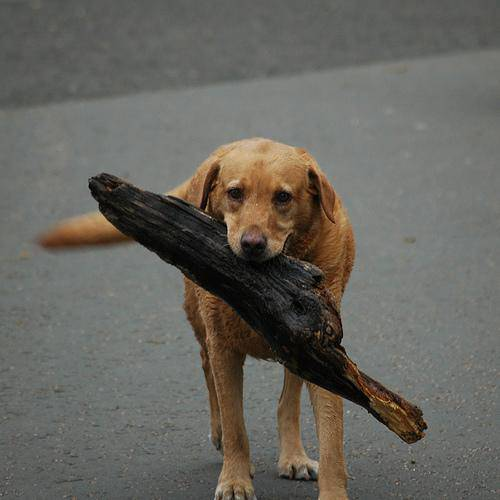

In [152]:
Image("/content/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

In [153]:
filenames = [f"/content/dog-breed-identification/train/{x}.jpg" for x in df.id]
filenames[:10]

['/content/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [154]:
breed_uniques = df.breed.unique()
dog_breeds = [breed == breed_uniques for breed in df.breed]

In [155]:
breed_uniques

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [156]:
X = filenames
Y = dog_breeds

In [157]:
NUM_IMAGES = 1000
NUM_EPOCHS = 100

In [158]:
X_TRAIN, X_VALID, Y_TRAIN, Y_VALID = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size=0.2, random_state=22)

## Turning data into tensors

- Read Image file
- Decode to 3 channel
- Convert to float32
- Resize to `(224. 224)`

In [159]:
def process_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, (224, 224))
  return img

In [160]:
def get_tensor_tuple(image_path, label):
  return process_image(image_path), label

## Turning Data into Batches

In [161]:
def make_batch(X, Y, batch_size=32, valid=False, test=False):
  if test:
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  elif valid:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data_batch = data.map(get_tensor_tuple).batch(batch_size)
    return data_batch
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_tensor_tuple).batch(batch_size)
    return data_batch

In [162]:
train_data = make_batch(X_TRAIN, Y_TRAIN)
valid_data = make_batch(X_VALID, Y_VALID, valid=True)
del X_TRAIN
del X_VALID
del Y_TRAIN
del Y_VALID

In [163]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [164]:
valid_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

## Visualizing TensorFlow Batches

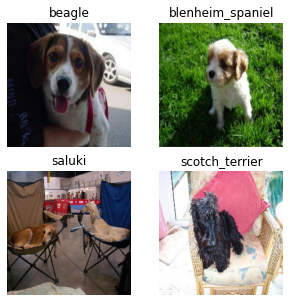

In [212]:
fig, ax = plt.subplots(2, 2, figsize=(5,5), squeeze=False)
train_images, train_label = next(train_data.as_numpy_iterator())
z = 0
for a in range(2):
  for b in range(2):
    ax[a, b].imshow(train_images[z])
    ax[a, b].set_title(breed_uniques[train_label[z].argmax()])
    ax[a, b].set_axis_off()
    z += 1
plt.show()
del train_images
del train_label

## Building a model

 Model Used: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [166]:
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(breed_uniques)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [167]:
def create_model(inpu=INPUT_SHAPE, out=OUTPUT_SHAPE, m_url=MODEL_URL):
  model = tf.keras.Sequential([
                               hub.KerasLayer(m_url),
                               tf.keras.layers.Dense(units=out, activation="softmax")
                               ])
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(inpu)
  return model

In [168]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

- TensorBoard
- Early stopping callback

### TensorBoard

In [169]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [170]:
import datetime
def create_tensorboard_callback():
  logdir = Path("/content/drive/My Drive/Colab/dog_breed/logs").joinpath(datetime.datetime.now().strftime("%d%m%Y-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stropping Callback

In [171]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [172]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [173]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=valid_data, validation_freq=1, callbacks=[tensorboard, early_stopping])
  return model

In [174]:
model = train_model()

Epoch 1/100
 2/25 [=>............................] - ETA: 5s - loss: 5.6197 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0916s vs `on_train_batch_end` time: 0.4139s). Check your callbacks.


25/25 [==============================] - 4s 166ms/step - loss: 4.6016 - accuracy: 0.0850 - val_loss: 3.4549 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 3s 125ms/step - loss: 1.6586 - accuracy: 0.6900 - val_loss: 2.1820 - val_accuracy: 0.4550
Epoch 3/100
25/25 [==============================] - 3s 125ms/step - loss: 0.5665 - accuracy: 0.9475 - val_loss: 1.7346 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 3s 125ms/step - loss: 0.2471 - accuracy: 0.9862 - val_loss: 1.5212 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 3s 124ms/step - loss: 0.1424 - accuracy: 0.9987 - val_loss: 1.4466 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 3s 124ms/step - loss: 0.0983 - accuracy: 1.0000 - val_loss: 1.4039 - val_accuracy: 0.6150
Epoch 7/100
25/25 [==============================] - 3s 124ms/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 1.3778 - val_accuracy: 0.6300
Epoch 8/100

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Colab/dog_breed/logs/"

In [176]:
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 1s 81ms/step


array([[4.5249681e-04, 4.1525584e-04, 1.1800965e-02, ..., 1.4712539e-04,
        8.7720058e-05, 2.5370356e-04],
       [1.0549992e-03, 3.7579488e-05, 1.2892149e-01, ..., 5.1396917e-05,
        2.7075777e-04, 1.7323307e-05],
       [1.8879513e-03, 2.5493771e-04, 1.0421764e-04, ..., 2.1258832e-06,
        5.7126541e-04, 3.4823393e-06],
       ...,
       [2.3024466e-03, 7.2348441e-05, 1.0782097e-01, ..., 3.4328445e-05,
        9.5598312e-04, 9.7871798e-06],
       [9.3542803e-06, 3.5930509e-04, 1.4727969e-04, ..., 4.1327712e-06,
        1.6039494e-05, 2.4356286e-05],
       [5.0940263e-05, 1.5225549e-05, 2.1677326e-04, ..., 3.1391439e-05,
        8.1289043e-05, 2.3606135e-05]], dtype=float32)

In [178]:
def get_pred_label(prediction):
  return breed_uniques[prediction.argmax()]

In [179]:
get_pred_label(prediction=predictions[22])

'border_collie'

In [180]:
def unbatchify_valid_data(valid_data):
  img_label_pack = []

  for image, label in valid_data.unbatch().as_numpy_iterator():
    img_label_pack.append((image, label))
  
  return img_label_pack

In [181]:
img_label_pack = unbatchify_valid_data(valid_data)

In [215]:
def visualize_predictions(img_label_pack, predictions ,n):
  fig, ax = plt.subplots(1, 4, figsize=(16,3))

  ax[0].imshow(img_label_pack[n][0])
  ax[0].set_axis_off()
  ex = ax[0].get_aspect()

  actual_breed = breed_uniques[img_label_pack[n][1].argmax()]
  ax[1].text(0.5, 0.5, actual_breed, ha="center", va="center")
  ax[1].text(0.5, 0.1, "True", ha="center")
  ax[1].set_aspect(ex)
  ax[1].set_xticks([])
  ax[1].set_yticks([])

  predicted_breed = breed_uniques[predictions[n].argmax()]
  predicted_accu = round(predictions[n].max() * 100, 2)
  ax[2].text(0.5, 0.5, f"{predicted_breed}\n\n{predicted_accu}", ha="center", va="center", color="green" if predicted_breed == actual_breed else "red")
  ax[2].text(0.5, 0.1, "Prediction", ha="center")
  ax[2].set_aspect(ex)
  ax[2].set_xticks([])
  ax[2].set_yticks([])

  actual_breed = breed_uniques[img_label_pack[n][1].argmax()]
  top_10_predictions = predictions[n].argsort()[-10:][::-1]
  heights = predictions[n][top_10_predictions]
  labels = breed_uniques[top_10_predictions]

  barlist = ax[3].bar(labels, heights, color="dimgrey")
  ax[3].xaxis.set_tick_params(rotation=90)

  if np.isin(actual_breed, labels):
    barlist[np.argmax(labels == actual_breed)].set_color('green')

  plt.show()

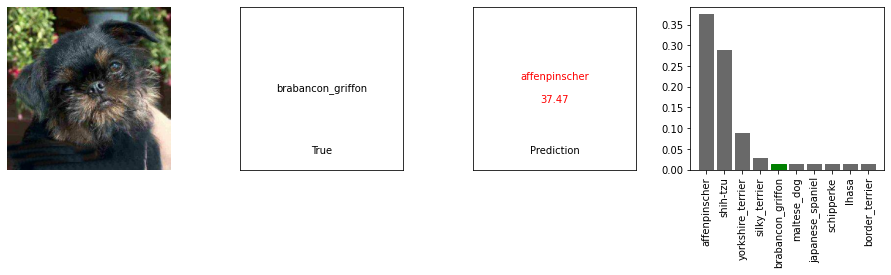

In [216]:
visualize_predictions(img_label_pack, predictions, 0)

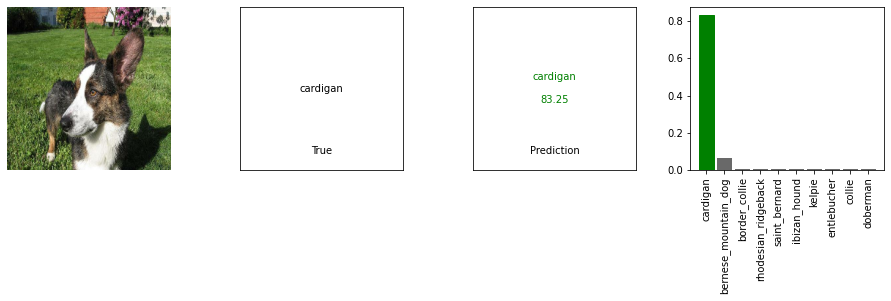

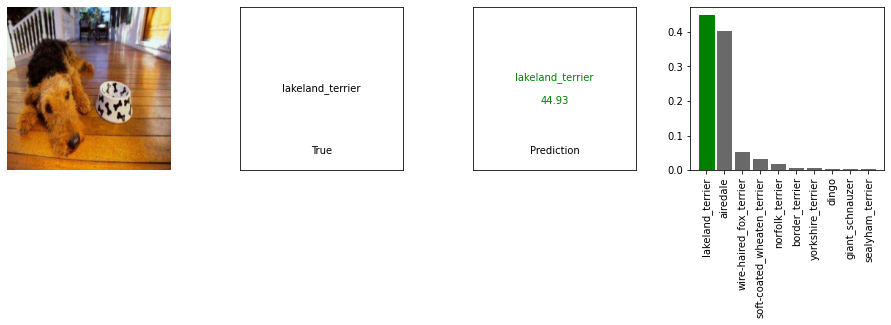

In [217]:
for x in range(8,10):
  visualize_predictions(img_label_pack, predictions, x)

In [219]:
def visualize_with_graph(img_label_pack, preidictions, n):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))

  ax[0].imshow(img_label_pack[n][0])
  ax[0].set_axis_off()

  actual_breed = breed_uniques[img_label_pack[n][1].argmax()]
  top_10_predictions = predictions[n].argsort()[-10:][::-1]
  heights = predictions[n][top_10_predictions]
  labels = breed_uniques[top_10_predictions]

  barlist = ax[1].bar(labels, heights, color="dimgrey")
  ax[1].xaxis.set_tick_params(rotation=90)

  if np.isin(actual_breed, labels):
      barlist[np.argmax(labels == actual_breed)].set_color('green')

  plt.show()

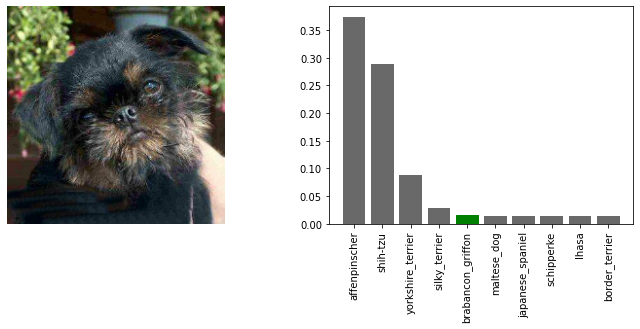

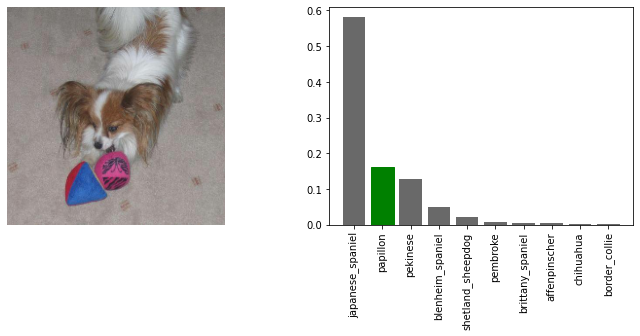

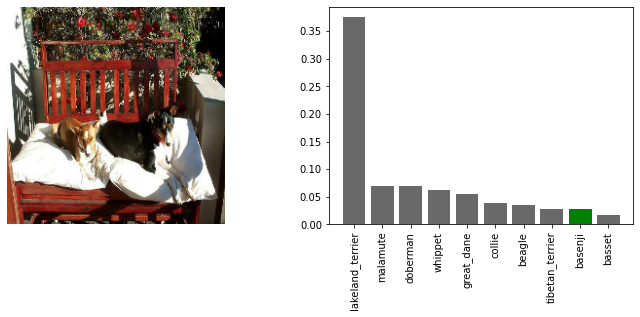

In [220]:
for x in range(0, 3):
  visualize_with_graph(img_label_pack, predictions, x)

In [187]:
def save_model(model, prefix=""):
  modeldir = Path("/content/drive/My Drive/Colab/dog_breed/models/").joinpath(f"{prefix}{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}-{NUM_IMAGES}.h5")
  model.save(modeldir)
  return modeldir

In [188]:
def load_model(model_path):
  print(f"Loading model: {model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [209]:
input("Press Enter to save...")
x = save_model(model)
model = load_model(x)

Press Enter to save...
Loading model: /content/drive/My Drive/Colab/dog_breed/models/20200906-082538-1000.h5


# img_label_pack

This is an unbatched tensor of the valid dataset with image and the label.

# breed_uniques

The original unique breeds list used to convert the boolean array to an actual string

# predictions

The predictions made on the valid/test tensors.
Type: np.array of floats (containing probabilities)

# train_data, valid_data

Batched train and valid data

# Creating The Full Model

In [190]:
input("Press Enter to Start...")

Press Enter to Start...


''

In [191]:
full_data = make_batch(X, Y)
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(breed_uniques)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
full_model = create_model()

In [192]:
tensorboard = create_tensorboard_callback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [193]:
full_model.fit(full_data, epochs=100, callbacks=[tensorboard, early_stopping])

Epoch 1/100
  2/320 [..............................] - ETA: 1:53 - loss: 5.8034 - accuracy: 0.0156  WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0829s vs `on_train_batch_end` time: 0.6220s). Check your callbacks.


320/320 [==============================] - 32s 100ms/step - loss: 1.3365 - accuracy: 0.6696
Epoch 2/100
320/320 [==============================] - 31s 97ms/step - loss: 0.4051 - accuracy: 0.8822
Epoch 3/100
320/320 [==============================] - 31s 97ms/step - loss: 0.2394 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 31s 98ms/step - loss: 0.1566 - accuracy: 0.9609
Epoch 5/100
320/320 [==============================] - 31s 97ms/step - loss: 0.1053 - accuracy: 0.9802
Epoch 6/100
320/320 [==============================] - 31s 97ms/step - loss: 0.0760 - accuracy: 0.9865
Epoch 7/100
320/320 [==============================] - 31s 95ms/step - loss: 0.0585 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0460 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 31s 98ms/step - loss: 0.0377 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 31s 97ms/step - loss: 0.0311

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Colab/dog_breed/logs/"

In [195]:
save_model(full_model, "FULLMODEL")

PosixPath('/content/drive/My Drive/Colab/dog_breed/models/FULLMODEL20200906-080839-1000.h5')

# Making predictions and saving them in `output.csv`

In [196]:
loaded_full_model = load_model('/content/drive/My Drive/Colab/dog_breed/models/FULLMODEL20200906-062821-1100.h5')

Loading model: /content/drive/My Drive/Colab/dog_breed/models/FULLMODEL20200906-062821-1100.h5


In [197]:
X_TEST = list(map(lambda x: str(x), Path("/content/dog-breed-identification/test").iterdir()))
X_TEST[:5]

['/content/dog-breed-identification/test/3ca5cc54176c11dfbfdd81d4e5c89fa5.jpg',
 '/content/dog-breed-identification/test/b1fb0b0c39c2e2736a0aded295e6c084.jpg',
 '/content/dog-breed-identification/test/6d08cad46028311c98717d3865c466b6.jpg',
 '/content/dog-breed-identification/test/62a44eaa5e7a2e0aa33eb823578a45d4.jpg',
 '/content/dog-breed-identification/test/bf72201525899d708b9858d1bc5fc92b.jpg']

In [198]:
test_batch = make_batch(X_TEST, _ ,test=True)

In [199]:
predictions = full_model.predict(test_batch, verbose=1)

324/324 [==============================] - 35s 107ms/step


In [200]:
x_test_id = list(map(lambda x:x.split("/")[-1][:-4], X_TEST))

In [201]:
output = pd.DataFrame(columns=np.insert(breed_uniques, 0, ["id"]))
output["id"] = x_test_id
output[breed_uniques] = predictions
#output = output[["id"] + list(sorted(breed_uniques))]
output.head()

,id,boston_bull,dingo,pekinese,bluetick,golden_retriever,bedlington_terrier,borzoi,basenji,scottish_deerhound,shetland_sheepdog,walker_hound,maltese_dog,norfolk_terrier,african_hunting_dog,wire-haired_fox_terrier,redbone,lakeland_terrier,boxer,doberman,otterhound,standard_schnauzer,irish_water_spaniel,black-and-tan_coonhound,cairn,affenpinscher,labrador_retriever,ibizan_hound,english_setter,weimaraner,giant_schnauzer,groenendael,dhole,toy_poodle,border_terrier,tibetan_terrier,norwegian_elkhound,shih-tzu,irish_terrier,kuvasz,...,brabancon_griffon,toy_terrier,chow,flat-coated_retriever,norwich_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,english_foxhound,gordon_setter,siberian_husky,newfoundland,briard,chesapeake_bay_retriever,dandie_dinmont,great_pyrenees,beagle,vizsla,west_highland_white_terrier,kerry_blue_terrier,whippet,sealyham_terrier,standard_poodle,keeshond,japanese_spaniel,miniature_poodle,pomeranian,curly-coated_retriever,yorkshire_terrier,pembroke,great_dane,blenheim_spaniel,silky_terrier,sussex_spaniel,german_short-haired_pointer,french_bulldog,bouvier_des_flandres,tibetan_mastiff,english_springer,cocker_spaniel,rottweiler
0,3ca5cc54176c11dfbfdd81d4e5c89fa5,2.786e-10,5.31304e-09,1.487e-08,1.40485e-10,1.09456e-08,1.56855e-07,5.71516e-09,4.65569e-09,1.97532e-07,4.27219e-10,1.7558e-08,3.12461e-10,1.94774e-09,3.66456e-11,0.000426805,2.72939e-08,0.000477309,1.64762e-09,5.23556e-07,1.98158e-08,0.000169586,6.04171e-09,7.91856e-08,2.38395e-10,6.3478e-10,5.11465e-09,1.5266e-07,1.48609e-07,2.77407e-11,9.92416e-08,1.66226e-10,9.86106e-08,1.64303e-07,2.21209e-06,2.96692e-11,3.95241e-10,1.5107e-12,0.250539,2.0256e-09,...,2.23541e-06,1.26598e-07,4.05596e-10,2.66654e-09,5.92323e-09,3.74957e-09,6.25094e-07,1.02222e-05,3.18001e-09,2.17108e-11,5.53818e-09,4.53736e-09,5.71704e-08,1.37365e-09,4.7917e-11,1.38906e-12,1.38326e-06,6.44211e-10,0.747677,1.37826e-06,1.55683e-07,3.93707e-09,1.76605e-09,2.31196e-08,6.58179e-09,2.75358e-10,1.34541e-08,6.97157e-08,1.48351e-10,9.97982e-11,1.49604e-09,1.22273e-08,4.89978e-09,1.55901e-09,1.27521e-09,4.43868e-09,1.79216e-11,3.04411e-10,2.68336e-10,1.84446e-10
1,b1fb0b0c39c2e2736a0aded295e6c084,9.04078e-10,7.54586e-09,3.08663e-09,1.18769e-09,0.000525366,3.23493e-11,3.385e-06,1.8212e-08,1.06582e-08,4.49681e-07,1.07346e-07,1.21224e-11,1.09054e-05,1.40798e-09,3.68003e-08,9.66276e-06,1.25928e-08,1.47743e-08,8.3784e-06,1.14935e-08,1.49774e-08,5.80667e-08,6.02459e-08,1.04618e-10,1.04678e-11,4.33639e-11,3.81774e-10,0.000337778,1.35429e-08,3.7532e-08,6.89231e-09,3.57568e-08,1.69411e-08,1.79997e-10,1.57084e-08,6.57881e-10,2.98587e-09,3.00584e-06,2.5251e-10,...,3.11025e-07,1.29464e-09,7.9131e-09,8.92978e-06,3.26438e-12,1.31661e-08,9.90874e-08,6.46606e-06,0.000117716,7.05808e-13,7.18908e-09,3.29578e-09,5.96775e-08,4.07556e-10,1.39581e-08,2.90723e-10,0.000102272,1.818e-11,2.39641e-10,1.69724e-09,2.51815e-10,1.74211e-07,1.8535e-10,2.03391e-09,4.82408e-08,1.16584e-06,1.17738e-09,2.84093e-07,5.20684e-10,1.87538e-10,2.82279e-06,0.000171398,9.958e-06,2.58633e-06,6.29099e-10,3.07246e-12,5.54409e-08,6.4452e-09,4.83365e-06,2.68053e-09
2,6d08cad46028311c98717d3865c466b6,3.33418e-09,5.72443e-12,0.0249069,9.9362e-08,4.04274e-10,2.34886e-10,2.91684e-10,2.11679e-09,2.77446e-11,2.47083e-06,1.01637e-13,1.27755e-07,3.63385e-10,2.65818e-11,6.25205e-09,2.38077e-11,6.28984e-14,1.38898e-09,1.76231e-09,6.8824e-10,1.1522e-10,1.58695e-11,1.13876e-11,1.09594e-11,5.5186e-09,2.26761e-10,1.59429e-11,4.78864e-07,2.77153e-10,7.43812e-09,2.212e-09,4.4598e-09,2.29621e-10,3.66375e-11,1.36143e-06,8.11033e-12,0.00656381,5.58728e-10,2.54021e-10,...,1.88516e-09,2.30634e-11,3.27105e-10,2.91773e-09,1.56718e-11,2.19093e-14,9.61839e-10,1.03459e-09,1.58005e-10,8.09343e-10,2.84949e-09,9.85025e-12,2.63301e-12,3.11385e-11,1.05188e-08,9.85788e-12,5.24095e-11,1.65707e-09,1.96628e-11,3.80689e-12,1.05662e-06,1.76473e-10,7.81723e-09,0.96848,7.72033e-11,6.28677e-07,6.68819e-12,1.18065e-09,1.38852e-11,1.5352e-07,4.73139e-07,5.24417e-10,2.34524e-08

In [202]:
output.to_csv("/content/drive/My Drive/Colab/dog_breed/output/output.csv", index=False)